In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import vgg19, VGG19_Weights
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import argparse
import numpy as np

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using:", device)

Using: cuda


In [7]:
import sys
sys.path.append('../models')

from SuperResolutionCNN import SuperResolutionCNN

student = SuperResolutionCNN().to(device)

In [8]:
sys.path.append('C:/Users/manas/image-sharpness/EDSR-PyTorch/src')
from model.edsr import make_model


In [9]:
args_teacher = argparse.Namespace(
    n_resblocks=16,         # number of residual blocks used in training
    n_feats=256,            # number of feature maps
    res_scale=1.0,          # residual scaling factor
    scale=[1],              # upscaling factor (1 for sharpness task)
    n_colors=3,             # RGB image (3 channels)
    rgb_range=1           # pixel value range (0-255)
)
teacher = make_model(args_teacher).to(device)
teacher.load_state_dict(torch.load('C:/Users/manas/image-sharpness/EDSR-PyTorch/experiment/edsr_sharpness_finetune_x1/model/model_1.pt'))
teacher.eval()
for param in teacher.parameters():
    param.requires_grad = False

C:\Users\manas\AppData\Local\Temp\ipykernel_32216\1550744298.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher.load_state_dict(torch.load('C:/Users/manas/image-sh

In [11]:
from torch.utils.data import DataLoader
from data.sharpness import Sharpness

class Args:
    def __init__(self):
        self.scale = [1]
        self.dir_data = 'C:/Users/manas/image-sharpness/EDSR-PyTorch/src/data'  # or wherever your `sharpness/train/HR, LR` dirs are
        self.batch_size = 8
        self.patch_size = 48
        self.n_colors = 3
        self.rgb_range = 1
        self.test_every = 1000

args = Args()

train_dataset = Sharpness(args, train=True)
train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, num_workers=0)
val_dataset = Sharpness(args, train=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0)

In [12]:
optimizer = torch.optim.Adam(student.parameters(), lr=1e-4)


In [13]:
lr, hr = train_dataset[0]
print(lr.shape, hr.shape)

torch.Size([3, 48, 48]) torch.Size([3, 48, 48])


In [14]:
class FeatureAdapter(nn.Module):
    def __init__(self, in_channels=256, out_channels=64):
        super(FeatureAdapter, self).__init__()
        self.adapter = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.adapter(x)

In [15]:
adapters = nn.ModuleList([
    FeatureAdapter(in_channels=256, out_channels=64).to(device) for _ in range(3)
])


In [16]:
def distillation_loss(s_out, t_out, s_feats, t_feats):
    pixel_loss = F.l1_loss(s_out, t_out.detach())
    feat_loss = sum(F.l1_loss(sf, tf.detach()) for sf, tf in zip(s_feats, t_feats))
    return pixel_loss + 0.1 * feat_loss

# ----- Training Loop -----
def train_student(student, teacher, train_loader, optimizer, num_epochs, device, adapters, save_dir="checkpoints"):
    student.to(device)
    teacher.to(device)
    teacher.eval()
    l1 = nn.L1Loss()
    mse = nn.MSELoss()
    max_grad_norm = 1.0

    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(num_epochs):
        student.train()
        epoch_loss = 0.0

        for i, (lr, hr) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
            lr, hr = lr.to(device), hr.to(device)

            if torch.isnan(lr).any() or torch.isnan(hr).any():
                raise ValueError(f"NaN detected in input at batch {i}")

            with torch.no_grad():
                t_out, t_feats = teacher(lr, return_features=True)

            s_out, s_feats = student(lr, return_features=True)

            if torch.isnan(s_out).any():
                print(f"❌ NaN in student output at batch {i}")
                print("Student output range:", s_out.min().item(), s_out.max().item())
                continue  # skip batch

        # Clamp student output before loss if needed
            s_out = torch.clamp(s_out, 0.0, 1.0)

            loss_pix = l1(s_out, hr)

        # Output distillation loss (optional)
            loss_distill = l1(s_out, t_out.detach())

        # Feature distillation loss (with adapters)
            loss_feat = 0
            for s_f, t_f, adapter in zip(s_feats, t_feats, adapters):
                adapted_t_feat = adapter(t_f.detach())
                loss_feat += mse(s_f, adapted_t_feat)

            total_loss = loss_pix + 0.5 * loss_distill + 0.1 * loss_feat

            optimizer.zero_grad()
            total_loss.backward()

        # ✅ Clip gradients
            torch.nn.utils.clip_grad_norm_(student.parameters(), max_grad_norm)

            optimizer.step()

            epoch_loss += total_loss.item()
        checkpoint_path = os.path.join(save_dir, f"student_epoch_{epoch+1}.pth")
        torch.save(student.state_dict(), checkpoint_path)
        print(f"✅ Saved model to {checkpoint_path}")

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.6f}")


In [17]:
train_student(student, teacher, train_loader, optimizer, num_epochs=5, device=device, adapters=adapters)

Epoch 1: 100%|██████████| 5551/5551 [36:52<00:00,  2.51it/s]


✅ Saved model to checkpoints\student_epoch_1.pth
Epoch [1/5], Loss: 0.053860


Epoch 2: 100%|██████████| 5551/5551 [40:00<00:00,  2.31it/s]


✅ Saved model to checkpoints\student_epoch_2.pth
Epoch [2/5], Loss: 0.022292


Epoch 3: 100%|██████████| 5551/5551 [38:51<00:00,  2.38it/s]


✅ Saved model to checkpoints\student_epoch_3.pth
Epoch [3/5], Loss: 0.019881


Epoch 4: 100%|██████████| 5551/5551 [38:11<00:00,  2.42it/s]


✅ Saved model to checkpoints\student_epoch_4.pth
Epoch [4/5], Loss: 0.018873


Epoch 5: 100%|██████████| 5551/5551 [1:48:28<00:00,  1.17s/it]    

✅ Saved model to checkpoints\student_epoch_5.pth
Epoch [5/5], Loss: 0.018370


In [12]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
def evaluate_model(model, dataloader, device):
    model.eval()
    psnr_total = 0.0
    ssim_total = 0.0
    base_psnr_total = 0.0
    base_ssim_total = 0.0
    count = 0

    with torch.no_grad():
        for lr, hr in tqdm(dataloader, desc="Evaluating"):
            lr, hr = lr.to(device), hr.to(device)

            sr = model(lr)
            sr = torch.clamp(sr, 0.0, 1.0)

            # Loop through batch
            for i in range(sr.size(0)):
                sr_np = sr[i].cpu().permute(1, 2, 0).numpy()
                hr_np = hr[i].cpu().permute(1, 2, 0).numpy()
                lr_np = lr[i].cpu().permute(1, 2, 0).numpy()

                sr_np = np.clip(sr_np, 0, 1)
                hr_np = np.clip(hr_np, 0, 1)
                lr_np = np.clip(lr_np, 0, 1)

                base_psnr = compare_psnr(hr_np, lr_np, data_range=1.0)
                base_ssim = compare_ssim(hr_np, lr_np, data_range=1.0, channel_axis=-1)
                psnr = compare_psnr(hr_np, sr_np, data_range=1.0)
                ssim = compare_ssim(hr_np, sr_np, data_range=1.0, channel_axis=-1)

                base_psnr_total += base_psnr
                base_ssim_total += base_ssim

                psnr_total += psnr
                ssim_total += ssim
                count += 1

    avg_psnr = psnr_total / count
    avg_ssim = ssim_total / count
    baseline_psnr = base_psnr_total / count
    baseline_ssim = base_ssim_total / count
    
    print(f"\n Average PSNR: {avg_psnr:.2f} dB")
    print(f"\n Average SSIM: {avg_ssim:.4f}")
    print(f"\n Baseline PSNR: {baseline_psnr:.2f} dB")
    print(f" Baseline SSIM: {baseline_ssim:.4f}")


In [13]:
student.load_state_dict(torch.load("checkpoints/student_epoch_5.pth", map_location=device))
student.to(device)

# Run evaluation
evaluate_model(student, val_loader, device)

C:\Users\manas\AppData\Local\Temp\ipykernel_32216\1479001389.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student.load_state_dict(torch.load("checkpoints/student_epoc


 Average PSNR: 34.84 dB

 Average SSIM: 0.9350

 Baseline PSNR: inf dB
 Baseline SSIM: 0.9266


In [32]:
import matplotlib.pyplot as plt

def visualize_triplet(model, dataloader, device):
    model.eval()
    model.to(device)

    with torch.no_grad():
        for lr, hr in dataloader:
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            sr = torch.clamp(sr, 0.0, 1.0)

            # Take first image in batch
            lr_img = lr[5].cpu().permute(1, 2, 0).numpy()
            sr_img = sr[5].cpu().permute(1, 2, 0).numpy()
            hr_img = hr[5].cpu().permute(1, 2, 0).numpy()

            # Clip to ensure valid pixel range
            lr_img = np.clip(lr_img, 0, 1)
            sr_img = np.clip(sr_img, 0, 1)
            hr_img = np.clip(hr_img, 0, 1)

            # Plot
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(lr_img)
            plt.title('LR (Input)')
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(sr_img)
            plt.title('SR (Student Output)')
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(hr_img)
            plt.title('HR (Ground Truth)')
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            break  # Only show first batch


In [16]:
def visualize_triplet(student_model, teacher_model, dataloader, device):
    student_model.eval()
    teacher_model.eval()
    student_model.to(device)
    teacher_model.to(device)

    with torch.no_grad():
        for lr, hr in dataloader:
            lr, hr = lr.to(device), hr.to(device)
            
            # ---------------- Student Inference ----------------
            start_student = time.time()
            sr = student_model(lr)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end_student = time.time()
            student_time_ms = (end_student - start_student) * 1000

            # ---------------- Teacher Inference ----------------
            start_teacher = time.time()
            tr = teacher_model(lr)
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            end_teacher = time.time()
            teacher_time_ms = (end_teacher - start_teacher) * 1000

            # Clamp outputs
            sr = torch.clamp(sr, 0.0, 1.0)
            tr = torch.clamp(tr, 0.0, 1.0)

            # Take first image in batch
            idx = 5 if lr.size(0) > 5 else 0
            lr_img = lr[idx].cpu().permute(1, 2, 0).numpy()
            sr_img = sr[idx].cpu().permute(1, 2, 0).numpy()
            tr_img = tr[idx].cpu().permute(1, 2, 0).numpy()
            hr_img = hr[idx].cpu().permute(1, 2, 0).numpy()

            # Clip to valid range
            lr_img = np.clip(lr_img, 0, 1)
            sr_img = np.clip(sr_img, 0, 1)
            tr_img = np.clip(tr_img, 0, 1)
            hr_img = np.clip(hr_img, 0, 1)

            # Plot 4 images
            plt.figure(figsize=(16, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(lr_img)
            plt.title('LR (Input)')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(sr_img)
            plt.title(f'Student Output\n{student_time_ms:.2f} ms')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(tr_img)
            plt.title(f'Teacher Output\n{teacher_time_ms:.2f} ms')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(hr_img)
            plt.title('HR (Ground Truth)')
            plt.axis('off')

            plt.suptitle("Student vs Teacher Output with Inference Time", fontsize=14)
            plt.tight_layout()
            plt.show()
            break  # Only show first batch

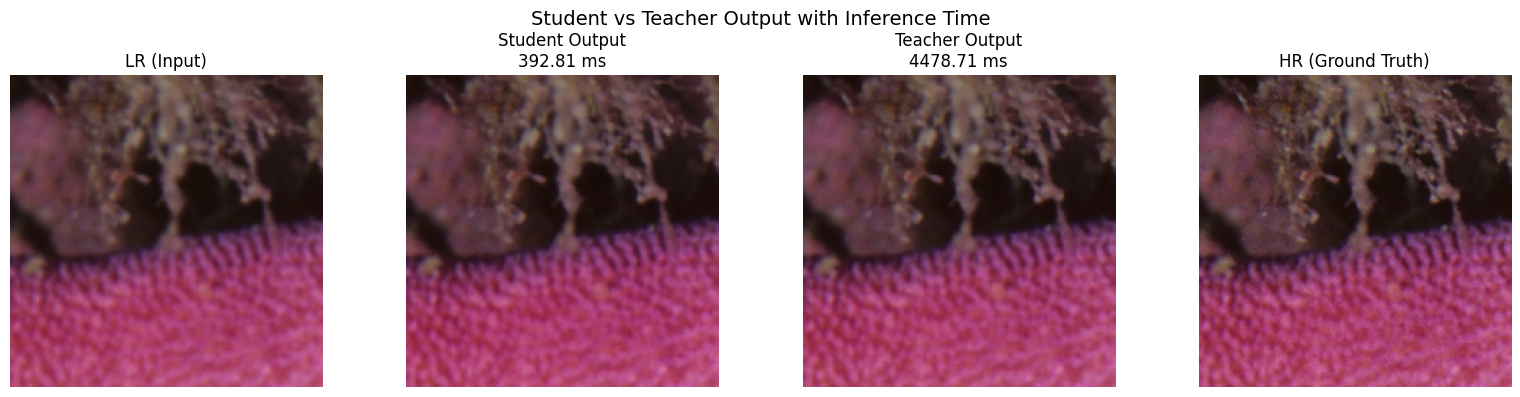

In [21]:
visualize_triplet(student, teacher, val_loader, device)

In [20]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def load_image_as_tensor(path):
    image = Image.open(path).convert("RGB")
    transform = transforms.ToTensor()  # Converts to [C,H,W] with values in [0,1]
    tensor = transform(image).unsqueeze(0)  # Add batch dim
    return tensor


In [35]:
def run_student_inference(student, lr_tensor, device):
    student.eval()
    lr_tensor = lr_tensor.to(device)

    with torch.no_grad():
        sr = student(lr_tensor)
        sr = torch.clamp(sr, 0.0, 1.0)
    
    return sr.cpu().squeeze(0)  # Remove batch dim


In [36]:
import matplotlib.pyplot as plt
import numpy as np

def tensor_to_numpy_img(tensor):
    img = tensor.permute(1, 2, 0).numpy()  # [C,H,W] → [H,W,C]
    img = np.clip(img, 0, 1)
    return img

def visualize_2k_output(lr_path, hr_path, student, device):
    # Load tensors
    lr = load_image_as_tensor(lr_path)
    hr = load_image_as_tensor(hr_path)
    
    # Inference
    sr = run_student_inference(student, lr, device)
    
    # Convert to images
    lr_img = tensor_to_numpy_img(lr.squeeze(0).cpu())
    sr_img = tensor_to_numpy_img(sr)
    hr_img = tensor_to_numpy_img(hr.squeeze(0).cpu())
    
    # Plot
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(lr_img)
    plt.title("LR Input")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(sr_img)
    plt.title("Student Output")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(hr_img)
    plt.title("HR Ground Truth")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


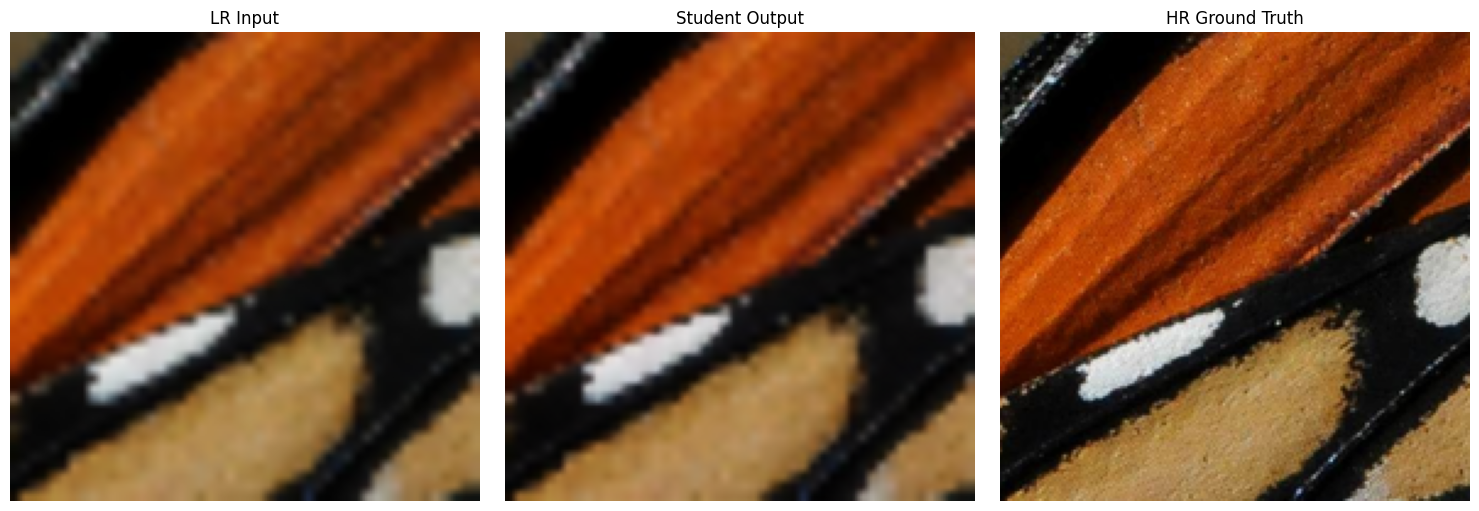

In [39]:
visualize_2k_output(
    lr_path="C:/Users/manas/image-sharpness/data/patches/LR_patches/0006_031.png",
    hr_path="C:/Users/manas/image-sharpness/data/patches/HR_patches/0006_031.png",
    student=student,
    device = device
)